# import

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
sys.executable

'/users/samova/lcances/.miniconda3/envs/pytorch-dev/bin/python'

In [19]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time
import pprint
from typing import Union

import numpy
# from torchsummary import summary

import torch
from torch.cuda import empty_cache
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from torch.optim.lr_scheduler import LambdaLR
# from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [20]:
from SSL.util.loaders import load_dataset, load_optimizer, load_callbacks, load_preprocesser
from SSL.util.model_loader import load_model
from SSL.util.checkpoint import CheckPoint, mSummaryWriter
from SSL.util.utils import reset_seed, get_datetime, track_maximum, DotDict
from SSL.ramps import Warmup, sigmoid_rampup
from SSL.losses import JensenShanon

from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

In [189]:
import augmentation_utils.spec_augmentations as sa
import matplotlib.pyplot as plt

from mlu.transforms.waveform import StretchPadCrop
from mlu.transforms.spectrogram import CutOutSpec

ImportError: cannot import name 'WaveformTransform' from 'mlu.transforms.waveform' (/users/samova/lcances/.miniconda3/envs/pytorch-dev/lib/python3.8/site-packages/mlu/transforms/waveform/__init__.py)

In [188]:
class StretchPadCrop(WaveformTransform):
	def __init__(
		self,
		rate: Union[Tuple[float, float], float] = (0.9, 1.1),
		align: str = "random",
		p: float = 1.0,
	):
		"""
			:param rate: The ratio of the signal used for resize.
			:param align: Alignment to use for cropping or padding. Can be 'left', 'right', 'center' or 'random'.
			:param p: The probability to apply the augmentation.
		"""
		super().__init__(p=p)
		self.rate = rate

		self.uniform = Uniform(low=rate[0], high=rate[1]) if not isinstance(rate, float) else None
		self.time_stretch = TimeStretchNearest()
		self.pad_crop = PadCrop(target_length=0, align=align)

	def apply(self, x: Tensor) -> Tensor:
		data_length = x.shape[-1]
		self.time_stretch.orig_freq = data_length
		self.time_stretch.new_freq = round(data_length * self._get_rate())
		self.pad_crop.set_target_length(data_length)

		x = self.time_stretch(x)
		x = self.pad_crop(x)

		return x

	def _get_rate(self) -> float:
		if self.uniform is not None:
			self.rate = self.uniform.sample().item()
		return self.rate

NameError: name 'WaveformTransform' is not defined

In [22]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="ubs8k", type=str)

args=parser.parse_args("")

# Prepare the dataset

In [23]:
_, train_loader, val_loader = load_dataset(args.dataset, "supervised", dataset_root=args.dataset_root)

100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


In [30]:
dataset = train_loader.dataset

In [31]:
from SSL.util.transforms import PadUpTo
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torchvision.transforms import ToTensor
from SSL.util.mixup import MixUpBatchShuffle

import numpy as np

T = nn.Sequential(
    PadUpTo(target_length=16000, mode="constant", value=0),
    MelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=512, n_mels=64),
    AmplitudeToDB(),
)
T = ToTensor()
M_ = MixUpBatchShuffle(alpha=0.4)
M = lambda x: M_(x, x)[0]

X = lambda idx: T(dataset[idx][0])
y = lambda idx: dataset[idx][1]

In [32]:
weak_1 = StretchPadCrop(rate=(0.5, 1.5), align="random", p=1.0)
strong_1 = StretchPadCrop(rate=(0.25, 1.75), align="random", p=1.0)

In [180]:
def generate_one(augmentation, idx):
    norm = lambda x: (x - x.min()) / (x.max() - x.min())
    origin = X(idx).squeeze()
    augmented = augmentation(origin)
        
    return origin, augmented

In [181]:
def display_one(origin, augmented, title):
    fig, (top, bot) = plt.subplots(nrows=2, ncols=1)
    fig.set_size_inches(15, 7)
    
#     fig.suptitle(title, fontsize=16)
    
    top.matshow(origin)
    bot.matshow(augmented)
    
    top.set_xticks([])
    fig.text(0.26, 0.5, 'Mel channel', va='center', rotation='vertical', fontsize=14)

    t = np.linspace(0, origin.shape[1], 5)
    bot.xaxis.set_ticks_position('bottom')
    bot.set_xticks(t)
    bot.set_xticklabels(range(5))
    bot.set_xlabel('Time (sec)', fontsize=14)
        
    plt.show()

# Augmentation StretchPadCrop(rate=(0.5, 1.5), align="random", p=ratio),

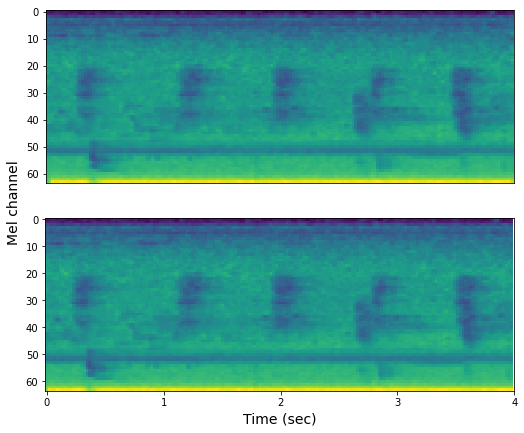

In [187]:
origin, augmented = generate_one(weak_1, 0)
display_one(origin, augmented, "weak supervised")

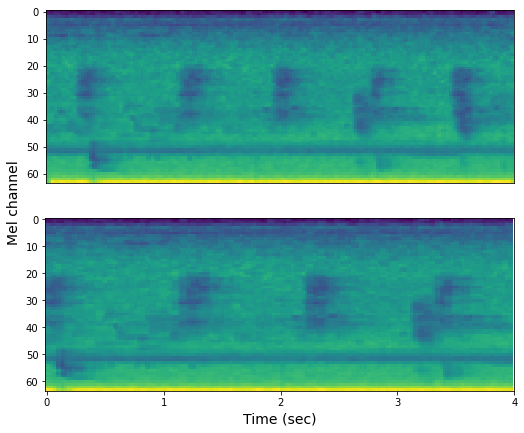

In [185]:
origin, augmented = generate_one(strong_1, 0)
display_one(origin, augmented, "strong supervised")

# Mixup

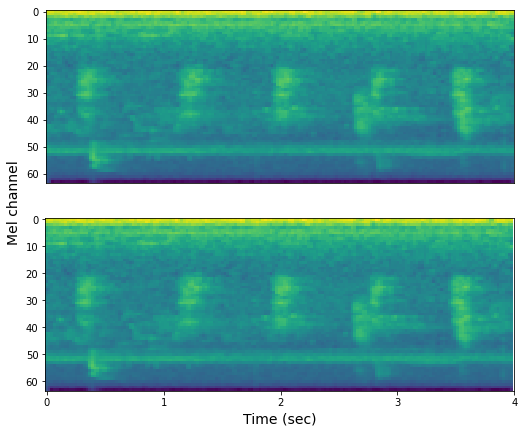

In [178]:
specs = [X(i) for i in range(20)]
batch = np.vstack(specs)
M_ = MixUpBatchShuffle(alpha=0.4)
M = lambda x: M_(x, x)[0]

origin = batch[0]
augmented = M(batch)[0]

display_one(origin, augmented, "Mixup augmentation")

In [400]:
aug = sa.FractalTimeDropout(
    ratio=1.0,
    min_chunk_size=20,
    min_chunk=1,
    max_chunk=1,
    void=True,
    cut=True
)
plt.matshow(aug(original) - original, cmap="Greys")

TypeError: __init__() got an unexpected keyword argument 'cut'

In [18]:
aug = sa.FractalTimeStretch(
    ratio=1.0,
    min_chunk_size=20,
)
plt.matshow(aug(original) - original, cmap="Greys")

NameError: name 'original' is not defined

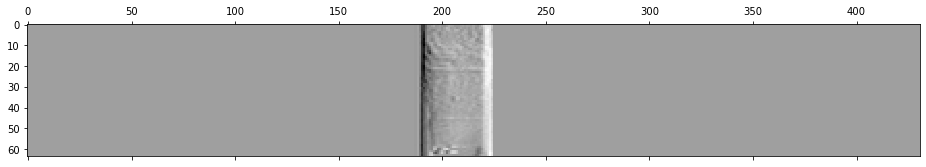

In [173]:
aug = sa.FractalStretch(1.0, freq_min_chunk_size=4, freq_max_chunk_size=8, time_min_chunk_size=16, time_max_chunk_size=48)
plt.matshow(aug(original) - original, cmap="Greys")

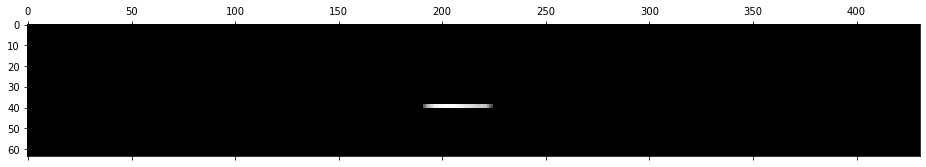

In [161]:
aug = sa.FractalDropout(1.0, freq_min_chunk_size=1, freq_max_chunk_size=3, freq_max_chunk=1, time_max_chunk=1)
plt.matshow(aug(original) - original, cmap="Greys")

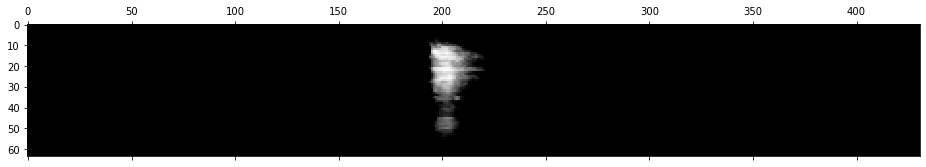

In [159]:
aug = sa.UniformSignNoise(1.0, 0.1, mini=-100, maxi=0)
plt.matshow(aug(original) - original, cmap="Greys")

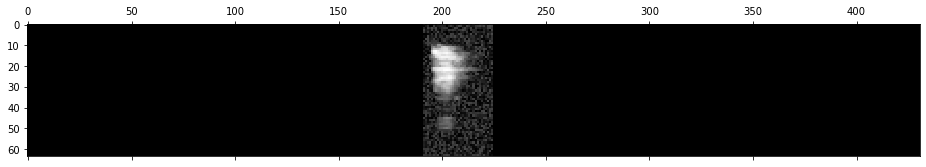

In [164]:
aug = sa.Noise(1.0, 10, mini=-100, maxi=0)
plt.matshow(aug(original) - original, cmap="Greys")